# Ranking Brain's Zones for Dementia Detection

This iPython Notebook is used to create a simple ranking of the various brain's zones for dementia detection using our neural network. First, we must install the tools for dealing with NiFTY files and all the additional required libraries. We use Pipenv to deal with virtual environments.

In [1]:
!pipenv install

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Installing dependencies from Pipfile.lock (ab9b16)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


In [2]:
import nibabel as nib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Exploration of the Atlas

In [3]:
atlas = nib.load("atlas.nii.gz")

Let's get a frame from the atlas (converted to numpy array for easier access).

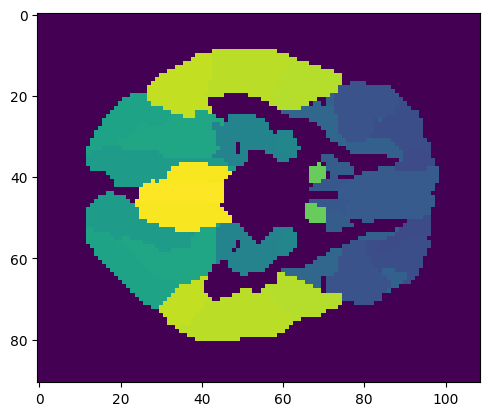

In [4]:
atlasarr = atlas.get_fdata()[:,:,30]
plt.imshow(atlasarr)

The content of such array can be summarized to the following numbers, each of which is associated to a brain's zone, as shown in the [original web page for this atlas](https://neurovault.org/images/14255/).

In [5]:
print(np.unique(atlasarr))

[   0. 2101. 2102. 2201. 2202. 2321. 2322. 2501. 2502. 2611. 2612. 2701.
 2702. 2811. 2812. 2821. 2822. 2831. 2832. 3001. 3002. 4101. 4102. 4111.
 4112. 4201. 4202. 5001. 5021. 5022. 5301. 5302. 5401. 5402. 7001. 7002.
 8111. 8112. 8121. 8122. 8201. 8202. 8301. 8302. 9021. 9022. 9031. 9032.
 9041. 9042. 9110. 9120. 9130.]


Thus, we can simply mask a zone by searching for it in the array. Here, I'm using numpy's *masked arrays* to do that.

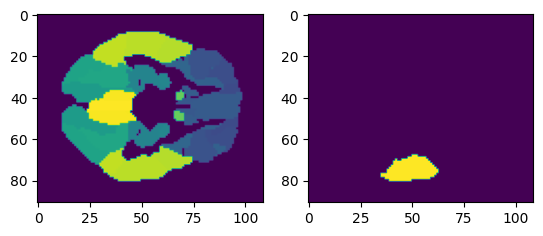

In [6]:
TO_SEARCH = 8201 # 8201: temporal_mid_l
f, ax = plt.subplots(1, 2)
ax[0].imshow(atlasarr)
ax[1].imshow(np.ma.masked_not_equal(atlasarr, TO_SEARCH).filled(0))


In [7]:
heatmap = np.load("pos_mean_pet.npy")
heatmap.shape, atlas.get_fdata().shape

((128, 128, 50), (91, 109, 91))

In [8]:
def fix_heat_dim(heat):
    # Both array and heatmap are numpy arrays
    heat2 = np.full((128,128,128), 0, dtype=np.float64)
    heat2[:,:,39:89] = heat.copy()
    return heat2
def fix_atlas_dim(atlas):
    # Both array and heatmap are numpy arrays
    atlas2 = np.full((128,128,128), 0, dtype=np.float64)
    atlas2[19:110,10:119,19:110] = atlas.copy()
    return atlas2
atlas_fixed = fix_atlas_dim(atlas.get_fdata())

In [9]:
heat_mri_pos = fix_heat_dim(np.load("resized_pos_mri.npy"))
heat_mri_neg = fix_heat_dim(np.load("resized_neg_mri.npy"))
heat_pet_pos = fix_heat_dim(np.load("pos_mean_pet.npy"))
heat_pet_neg = fix_heat_dim(np.load("neg_mean_pet.npy"))

In [10]:
a = np.array([1,2,3,4,5])
b = np.array([5,6,7,8,9])
m = np.ma.masked_not_equal(a, 3)
np.ma.masked_where(m.mask, b)

masked_array(data=[--, --, 7, --, --],
             mask=[ True,  True, False,  True,  True],
       fill_value=999999)

In [11]:
df = pd.read_csv("AAL2_Atlas_Labels.csv", names=["name", "intensity"], index_col=0)
df.head()

,name,intensity
1,Precentral_L,2001
2,Precentral_R,2002
3,Frontal_Sup_2_L,2101
4,Frontal_Sup_2_R,2102
5,Frontal_Mid_2_L,2201


In [12]:
l = []
for _, row in df.iterrows():
    to_search = row['intensity']
    mask = np.ma.masked_not_equal(atlas_fixed, to_search)
    pet_neg = np.ma.masked_where(mask.mask, heat_pet_neg).filled(0)
    pet_pos = np.ma.masked_where(mask.mask, heat_pet_pos).filled(0)
    mri_neg = np.ma.masked_where(mask.mask, heat_mri_neg).filled(0)
    mri_pos = np.ma.masked_where(mask.mask, heat_mri_pos).filled(0)
    d = {
        'part': row['name'],
        'Negative PET mean': pet_neg.mean(),
        'Positive PET mean': pet_pos.mean(),
        'Negative MRI mean': mri_neg.mean(),
        'Positive MRI mean': mri_pos.mean(),
        'Negative PET count': np.count_nonzero(pet_neg),
        'Positive PET count': np.count_nonzero(pet_pos),
        'Negative MRI count': np.count_nonzero(mri_neg),
        'Positive MRI count': np.count_nonzero(mri_pos),
        'Negative PET sum': pet_neg.sum(),
        'Positive PET sum': pet_pos.sum(),
        'Negative MRI sum': mri_neg.sum(),
        'Positive MRI sum': mri_pos.sum()
    }
    l += [d]
results = pd.DataFrame(l)
del l;

In [24]:
results.to_csv("heatmap_importance.csv")
results.head()

,part,Negative PET mean,Positive PET mean,Negative MRI mean,Positive MRI mean,Negative PET count,Positive PET count,Negative MRI count,Positive MRI count,Negative PET sum,Positive PET sum,Negative MRI sum,Positive MRI sum
0,Precentral_L,0.000532,0.000576,0.000461,0.000220,3038,3038,3038,3038,1114.707249,1207.641298,966.749000,461.281862
1,Precentral_R,0.000427,0.000417,0.000250,0.000168,2747,2747,2681,2681,894.622546,873.637698,524.047146,352.063251
2,Frontal_Sup_2_L,0.000673,0.000678,0.000188,0.000074,4472,4472,2321,2321,1411.819159,1421.030193,393.742026,154.649817
3,Frontal_Sup_2_R,0.000678,0.000649,0.000242,0.000086,4689,4689,2541,2541,1422.782633,1361.921047,506.841342,180.509450
4,Frontal_Mid_2_L,0.000763,0.000788,0.000188,0.000094,4509,4509,3160,3160,1599.345071,1653.073211,395.204205,198.130331


In [23]:
pos_mri_best = results.sort_values(by="Positive MRI mean").head()["part"]
neg_mri_best = results.sort_values(by="Negative MRI mean").head()["part"]
pos_pet_best = results.sort_values(by="Positive PET mean").head()["part"]
neg_pet_best = results.sort_values(by="Negative PET mean").head()["part"]

print(f"Best for MRI:\n\tNeg: {', '.join(neg_mri_best)}\n\tPos: {', '.join(pos_mri_best)}")
print(f"Best for PET:\n\tNeg: {', '.join(neg_pet_best)}\n\tPos: {', '.join(pos_pet_best)}")

Best for MRI:
	Neg: Cerebelum_10_L, Cerebelum_10_R, Cerebelum_7b_L, Cerebelum_7b_R, Cerebelum_9_R
	Pos: Cerebelum_10_L, Cerebelum_7b_L, Cerebelum_7b_R, Cerebelum_10_R, Cerebelum_8_L
Best for PET:
	Neg: Cerebelum_10_R, Cerebelum_10_L, Cerebelum_7b_R, Cerebelum_7b_L, Cerebelum_9_R
	Pos: Cerebelum_10_L, Cerebelum_7b_R, Cerebelum_10_R, Cerebelum_7b_L, Cerebelum_9_R


In [15]:
results['Negative PET mean'].head()

0    0.000532
1    0.000427
2    0.000673
3    0.000678
4    0.000763
Name: Negative PET mean, dtype: float64

In [16]:
print(type(np.ma.masked_not_equal(atlas.get_fdata(), TO_SEARCH)))

for p in df['intensity']:
    print(np.unique(np.ma.masked_not_equal(atlas.get_fdata(), p).filled(0)))

<class 'numpy.ma.core.MaskedArray'>
[   0. 2001.]
[   0. 2002.]
[   0. 2101.]
[   0. 2102.]
[   0. 2201.]
[   0. 2202.]
[   0. 2301.]
[   0. 2302.]
[   0. 2311.]
[   0. 2312.]
[   0. 2321.]
[   0. 2322.]
[   0. 2331.]
[   0. 2332.]
[   0. 2401.]
[   0. 2402.]
[   0. 2501.]
[   0. 2502.]
[   0. 2601.]
[   0. 2602.]
[   0. 2611.]
[   0. 2612.]
[   0. 2701.]
[   0. 2702.]
[   0. 2801.]
[   0. 2802.]
[   0. 2811.]
[   0. 2812.]
[   0. 2821.]
[   0. 2822.]
[   0. 2831.]
[   0. 2832.]
[   0. 3001.]
[   0. 3002.]
[   0. 4001.]
[   0. 4002.]
[   0. 4011.]
[   0. 4012.]
[   0. 4021.]
[   0. 4022.]
[   0. 4101.]
[   0. 4102.]
[   0. 4111.]
[   0. 4112.]
[   0. 4201.]
[   0. 4202.]
[   0. 5001.]
[   0. 5002.]
[   0. 5011.]
[   0. 5012.]
[   0. 5021.]
[   0. 5022.]
[   0. 5101.]
[   0. 5102.]
[   0. 5201.]
[   0. 5202.]
[   0. 5301.]
[   0. 5302.]
[   0. 5401.]
[   0. 5402.]
[   0. 6001.]
[   0. 6002.]
[   0. 6101.]
[   0. 6102.]
[   0. 6201.]
[   0. 6202.]
[   0. 6211.]
[   0. 6212.]
[   0. 6221.